In [29]:
# Libraries
library(pracma)
library(VineCopula)
library(ggplot2)

In [30]:
# Settings:
freq <- "Monthly"
freq1 <- 20 # weights rebalancing frequency: monthly (every 20 days)
d <- 6 # portfolio dimension (number of stocks)
T0 <- 1000 # in-sample size
alpha = 0.05 # coverage level for expected shortfall
N = 100000 # Number of simulated samples to solve portfolio optimizaion problem

## 1. Load and merge the data

In [31]:
stocks <- c("AAPL", "AMZN", "MSFT", "GOOGL", "BRK-A", "JPM")
datalist <- list() 
t1 <- as.integer(ISOdate(2016,1,1,hour=0))
t2 <- as.integer(ISOdate(2022,9,6,hour=0))

for (stock in stocks) {
    url <- paste("https://query1.finance.yahoo.com/v7/finance/download/",
                 stock,
                 "?period1=",
                 as.integer(t1),
                 "&period2=",
                 as.integer(t2),
                 "&interval=1d&events=history&includeAdjustedClose=true",
                 sep="")
    data <- read.csv(url)
    data['Date'] <- as.Date(data$Date)    
    datalist[[stock]] <- data.frame(date=data$Date,price=data$Adj.Close)
}

# Merge
prices <- data.frame(datalist$AAPL)
colnames(prices) <- c('date','AAPL')
for (i in 2:length(datalist)) {
    temp <- datalist[[i]]
    colnames(temp) <- c('date', stocks[i])
    prices <- merge(prices,temp,by="date")
}
prices <- data.frame(prices)
head(prices)

,date,AAPL,AMZN,MSFT,GOOGL,BRK.A,JPM
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-04,24.15150,31.8495,49.26915,37.9720,196295,53.08822
2,2016-01-05,23.54628,31.6895,49.49391,38.0765,197000,53.18002
3,2016-01-06,23.08548,31.6325,48.59485,37.9665,197415,52.41232
4,2016-01-07,22.11117,30.3970,46.90459,37.0500,195580,50.29279
5,2016-01-08,22.22809,30.3525,47.04845,36.5455,193900,49.16627
6,2016-01-11,22.58801,30.8870,47.02147,36.6535,193060,49.09118


## 2. Generate log-returns

In [32]:
genretdf <- function(pricesdf, nonans = TRUE) {
  prices <- data.matrix(pricesdf)
  ret <- 100*(diff(log(prices[,2:ncol(prices)])))  
  TT <- nrow(ret)
  pricesdf <- pricesdf[1:TT+1,]
  date <- as.Date(pricesdf$date) 
  retdf <- data.frame(date,ret)
  if (nonans==TRUE){
    retdf <- na.omit(retdf) 
  }
  return(retdf)
}

retdf <- genretdf(prices, nonans=TRUE)
head(retdf)

,date,AAPL,AMZN,MSFT,GOOGL,BRK.A,JPM
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-05,-2.5378520,-0.50362874,0.45516288,0.2748248,0.3585099,0.1727647
2,2016-01-06,-1.9763998,-0.18003542,-1.83320727,-0.2893128,0.2104383,-1.4540951
3,2016-01-07,-4.3121028,-3.98411866,-3.54020396,-2.4435841,-0.9338609,-4.1280028
4,2016-01-08,0.5274074,-0.14649671,0.30622983,-1.3710210,-0.8626941,-2.2653867
5,2016-01-11,1.6062296,1.74564316,-0.05735734,0.2950807,-0.4341541,-0.1528475
6,2016-01-12,1.4408922,0.02428559,0.91360951,1.6599241,0.4857138,0.2207226


## 3. Helper functions
3.1. Log-Likelihood of the GJR-GARCH(1,1,1) with skewed-t errors. Required for maximum likelihood parameter estimation.

In [33]:
# Likelihood of the GJR-GARCH(1,1,1) with skewed-t errors
GJRGARCHloglik <- function(par, ret) {
  # Mean: unconditional mean
  # Error's distribution: skewed-t of Hansen (1994)  
  TT <- length(ret)
  
  # Starting values:
  rbar <- mean(ret)
  condVar <- matrix(rep(0,TT),TT)
  epsi <- matrix(rep(0,TT),TT)
  z <- matrix(rep(0,TT),TT)
  condVar[1] <- mean((ret-rbar)^2)
  epsi[1] <- sqrt(condVar[1])
  z[1] <- 1
  
  # Unconditional mean:
  mu <- par[1]
  
  # Conditional variance:
  # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
  b0 <- par[2] # omega
  b1 <- par[3] # beta
  b2 <- par[4] # alpha
  b3 <- par[5] # gamma
    
  # GJR-GARCH(1,1) :
  for (t in 2 : TT)  {
    condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
    z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
    epsi[t] <- z[t]*sqrt(condVar[t]) 
  }
  sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )

  # Skewed-t shape parameters:
  a <- tail(par,2) 
  nu <- a[1] # degrees of freedom
  lambda <- a[2] # skewnes parameter
  
  # Log-likelihood
  logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
  c = exp(logc) 
  a <- 4*lambda*c*((nu-2)/(nu-1))
  logb <- 0.5*log(1 + 3*lambda^2 - a^2)
  b <- exp(logb)
  f1 <- which(z <  (-a/b))
  f2 <- which(z >= (-a/b))
  ll <- rep(NaN,length(z))
  ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
  ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
  ll[f1] <- ll1
  ll[f2] <- ll2 
  LL <- -sum(ll)
  return(LL)
}

3.2. Skewed-t CDF

In [34]:
# Skewed-t CDF
skewtcdf <- function(x, nu, lambda) {
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(x <  -a/b)
  f2 <- which(x >= -a/b)
  
  y1 <- (b*x+a)/(1-lambda)*sqrt(nu/(nu-2))  
  y2 <- (b*x+a)/(1+lambda)*sqrt(nu/(nu-2)) 
  
  p = rep(NaN,length(x))
  p[f1] <- (1-lambda)*pt(y1[f1], nu, lower.tail = TRUE, log.p = FALSE)
  p[f2] <- ((1-lambda)/2  + (1+lambda)*(pt(y2[f2], nu, lower.tail = TRUE, log.p = FALSE)-0.5))
  
  return(p) 
}

3.3. Inverse of the Skewed-t CDF

In [35]:
skewtinv <- function(p, nu, lambda) {
c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
a <- 4*lambda*c*((nu-2)/(nu-1))
b <- sqrt(1 + 3*lambda^2 - a^2)
  
f1 <- which(p <  (1-lambda)/2)
f2 <- which(p >= (1-lambda)/2)

inv1 <- ((1-lambda)/b)*sqrt((nu-2)/nu)*qt(p[f1]/(1-lambda),nu) - a/b
inv2 <- ((1+lambda)/b)*sqrt((nu-2)/nu)*qt(0.5+1/(1+lambda)*(p[f2]-(1-lambda)/2),nu) - a/b

x <- rep(NaN,length(p))
x[f1] <- inv1
x[f2] <- inv2
return(x) 
}

3.4. Function that computes GJR-GARCH(1,1,1) outputs: zdata, conditional variance, sigma prime

In [36]:
GJRGARCHoutputs <- function(par, ret) {
  # Conditional volatility: GJR-GARCH(1,1,1)
  # Mean: unconditional mean
  # Error distribution: Skewed-t of Hansen (1994) 
  TT <- length(ret)
  
  # Starting values:
  rbar <- mean(ret)
  condVar <- matrix(rep(0,TT),TT)
  epsi <- matrix(rep(0,TT),TT)
  z <- matrix(rep(0,TT),TT)
  condVar[1] <- mean((ret-rbar)^2)
  epsi[1] <- sqrt(condVar[1])
  z[1] <- 1
  
  # Unconditional mean:
  mu <- par[1]
  
  # Conditional variance:
  # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
  b0 <- par[2] # omega
  b1 <- par[3] # beta
  b2 <- par[4] # alpha
  b3 <- par[5] # gamma
    
  # GJR-GARCH(1,1) :
  for (t in 2 : TT)  {
  condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
  z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
  epsi[t] <- z[t]*sqrt(condVar[t]) 
  }
  sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
 
  # Distribution parameters:
  a <- tail(par,2) 
  nu <- a[1] # degrees of freedom
  lambda <- a[2] # skewnes parameter

  # Output
  out <- list(z=z,condVar=condVar,sigmaPrime=sigmaPrime)
  return(out)
}

3.5. Objective function in the portfolio optimization problem

In [37]:
# Objective function (expected shortfall)
ES_RockafellarUryasev2000 <- function(x0, rdata, alpha) {
  m = ncol(rdata)
  v = x0[1]
  w = matrix(x0[1:m+1])
  rp = t(w)%*%t(rdata)
  di = pmax(0, v-rp)
  ES = - (1/alpha)*mean(di) + v
  ES = - ES
  return(ES)
}

## 4. Rolling window estimation

In [38]:
# Settings
TT <- nrow(retdf)
OOS <- TT-T0 
marginparnames <- c("mu","omega","beta","alpha","gamma","nu","lambda")
weights <- matrix(rep(NaN,d*OOS),OOS)
colnames(weights) <- names(retdf[,2:ncol(retdf)])
RealRet <- matrix(rep(NaN,OOS),OOS) # monthly rebalancing
RealRet2 <- matrix(rep(NaN,OOS),OOS) # no rebalancing, use always the first optimal strategy 
EW_port <- matrix(rep(NaN,OOS),OOS) # equally-weighted
equallyweights <- matrix(rep(1/d,d),1)

In [39]:
# Rolling  window loop:
t <- 1
while (t < OOS) {
    tt <- t+T0-1
    
    # Margins
    par1 <- NULL
    for (i in names(retdf[,2:ncol(retdf)])){ 
      ret <- retdf[t:tt,i]
      mu0 <- mean(ret)
      omega0 <- 0.01 ; beta0 <- 0.87 ; alpha0 <- 0.08 ; gamma0 <- 0.09
      nu0 <- 4 ; lambda0 <- - 0.2
      par0 <- c(mu0, omega0, beta0, alpha0, gamma0, nu0, lambda0) 

      lb <- c(-100, rep(0.001,3), -1, 2.01, -0.99) # lower bounds for GARCH(1,1) parameters: [mu, omega(>0), beta(>0), alpha(>0), gamma(=>0), nu(>2), lambda > -0.99]
      ub <- c(rep(100,6), 0.999)                      # upper bounds for GARCH(1,1) parameters: [mu, omega, beta, alpha, gamma, nu, lamnda < 0.99]
      A  <- matrix(rbind(c(0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, -1, -1, 0, 0)), 2)   # alpha + beta + 0.5*gamma < 1
      b  <- matrix(c(0.999, -0.001),2)    
      Aeq  <- NULL
      beq  <- NULL
      x1 <- fmincon(x0 = par0, 
                    ret = ret, 
                    GJRGARCHloglik, # objective function
                    ub=ub, lb=lb, 
                    A=A, b=b, 
                    Aeq=Aeq, beq=beq, tol=1e-03)
      par0 <- x1$par
      par1 <- rbind(par1,par0)
    }
    rownames(par1) <- names(retdf[,2:ncol(retdf)])
    colnames(par1) <- marginparnames
    
    # Copula
    v <- list()
    dd <- d + 1
    for (i in names(retdf[,2:dd])){
      ret <- as.matrix(retdf[t:tt,i])
      out <- GJRGARCHoutputs(par=as.numeric(par0), ret=ret) 
      z <- as.matrix(out$z)
      v[[i]] <- skewtcdf(z, as.numeric(par1[i,"nu"]), as.numeric(par1[i,"lambda"]))
    }

    vdata <- matrix(rep(NaN,d*nrow(retdf[t:tt,])), nrow(retdf[t:tt,]))
    colnames(vdata) <- names(retdf[,2:dd]) 
    for (i in names(retdf[,2:dd])) {
      vdata[,i] <- v[[i]]
    }
    
    # R-Vine Copula
    RVineStruct <- RVineStructureSelect(data=vdata, familyset = NA, type="RVine",
                                          selectioncrit = "BIC",
                                          indeptest = TRUE, level = 0.05,
                                          trunclevel = NA, progress = FALSE,
                                          weights = NA,
                                          treecrit = "tau",
                                          rotations = TRUE,
                                          se = FALSE,
                                          presel = FALSE,
                                          method = "mle",
                                          cores = 1)

    # Portfolio optimization 
    w <- matrix(rep(NaN,d),1)

    # Simulate dependent uniforms, v, from the copula
    RVinePar <- RVineStruct
    RVM <- RVineMatrix(Matrix = RVinePar$Matrix, family = RVinePar$family,
                         par = RVinePar$par, par2 = RVinePar$par2,
                         names=names(retdf[,2:dd]))

    vdata <- RVineSim(N, RVM, U = NULL)

    # z = F^(-1)(v) 
    zdata <- matrix(rep(NaN,N*d),N)
    colnames(zdata) <- names(retdf[,2:dd])
    for (i in names(retdf[,2:dd])){
      zdata[,i] <- skewtinv(vdata[,i],as.numeric(par1[i,"nu"]),as.numeric(par1[i,"lambda"]))
    }

    # r = mu + sqrt(ht)*z
    rdata <- matrix(rep(NaN,N*d),N)
    colnames(rdata) <- names(retdf[,2:dd])
    for (i in names(retdf[,2:dd])){
      ret <- as.numeric(retdf[t:tt,i])
      out <- GJRGARCHoutputs(par=as.matrix(par1[i,]), ret=ret) 
      sigmaprime <- as.numeric(out$sigmaPrime)
      rdata[,i] <- par1[i,"mu"] + sigmaprime*zdata[,i]
    }

    # Non-linear optimization
    # Starting values: 
    v0 <- -0.1
    w0 <- rep(1,d)*(1/d)  
    x0 <- matrix(c(v0,w0),1)

    # Optimization restrictions:
    lb <- c(-100, rep(0,d))  # lower bounds for x = (v,w1, ... ,wm)
    ub <- c( 100, rep(1,d))  # upper bounds for x = (v,w1, ... ,wm)
    A  <- - matrix(c(0, par1[ ,"mu"]),1)
    b  <- - (min(par1[ ,"mu"]) + (max(par1[ ,"mu"])-min(par1[ ,"mu"]))/1.3 ) # not the GMR portfolio, something a bit riskier
    Aeq  <- matrix(c(0, rep(1,d)),1)  # w1 + w2 + ... + wd = 1
    beq   <- 1 

    # Global minimum risk portfolio:
    x1 <- fmincon(x0=x0,
                  rdata=rdata,
                  alpha=alpha,
                  ES_RockafellarUryasev2000,
                  ub=ub,
                  lb=lb,
                  A=A,
                  b=b,
                  Aeq=Aeq,
                  beq=beq,
                  tol = 1e-04)

    # Variables final values
    xw <- x1$par
    w <- tail(xw, d) # corresponding weights for the minimum E(r) portfolio
    
    t0 <- t
    if (t+freq1-1 > OOS) {
        t1 <- OOS
    } else {
        t1 <- t+freq1-1
    }
    
    i <- 1
    for (j in t0:t1) {
        weights[j,] <- w
        RealRet[j,1] <- as.numeric(weights[j,]%*%as.numeric(matrix(retdf[tt+i,2:dd])))
        RealRet2[j,1] <- as.numeric(weights[1,]%*%as.numeric(matrix(retdf[tt+i,2:dd])))
        EW_port[j,1] <- as.numeric(equallyweights%*%as.numeric(matrix(retdf[tt+i,2:dd])))
        i <- i + 1
      }
    t <- t + freq1
}

In [40]:
# Evolution of Wealth
W0 <- 1000 # initial investment

wealth <- matrix(rep(NaN,OOS*3),OOS)
colnames(wealth) <- c("Optimization (monthly rebalancing)","Optimization (no rebalancing)","Equally-weighted")

for (t in 1:OOS) {
    if (t == 1) {
        wealth[t,"Optimization (monthly rebalancing)"] <- W0*(1+RealRet[t]/100)
        wealth[t,"Optimization (no rebalancing)"] <- W0*(1+RealRet2[t]/100)
        wealth[t,"Equally-weighted"] <- W0*(1+EW_port[t]/100)  
    } else if (t != 1) {
        wealth[t,"Optimization (monthly rebalancing)"] <- wealth[t-1,"Optimization (monthly rebalancing)"]*(1+RealRet[t]/100)
        wealth[t,"Optimization (no rebalancing)"] <- wealth[t-1,"Optimization (no rebalancing)"]*(1+RealRet2[t]/100)
        wealth[t,"Equally-weighted"] <- wealth[t-1,"Equally-weighted"]*(1+EW_port[t]/100) 
    }
}

Date <- retdf$date
Date <- as.Date(subset(retdf$date, (retdf$date >=  Date[T0+1]))  )
wealthdf <- data.frame(Date,wealth)
wealthdf <- na.omit(wealthdf) 
colnames(wealthdf) <- c("Date","OptimizationA","OptimizationB","EW")

## 5. Results
### 5.1. Evolution of wealth's plot 

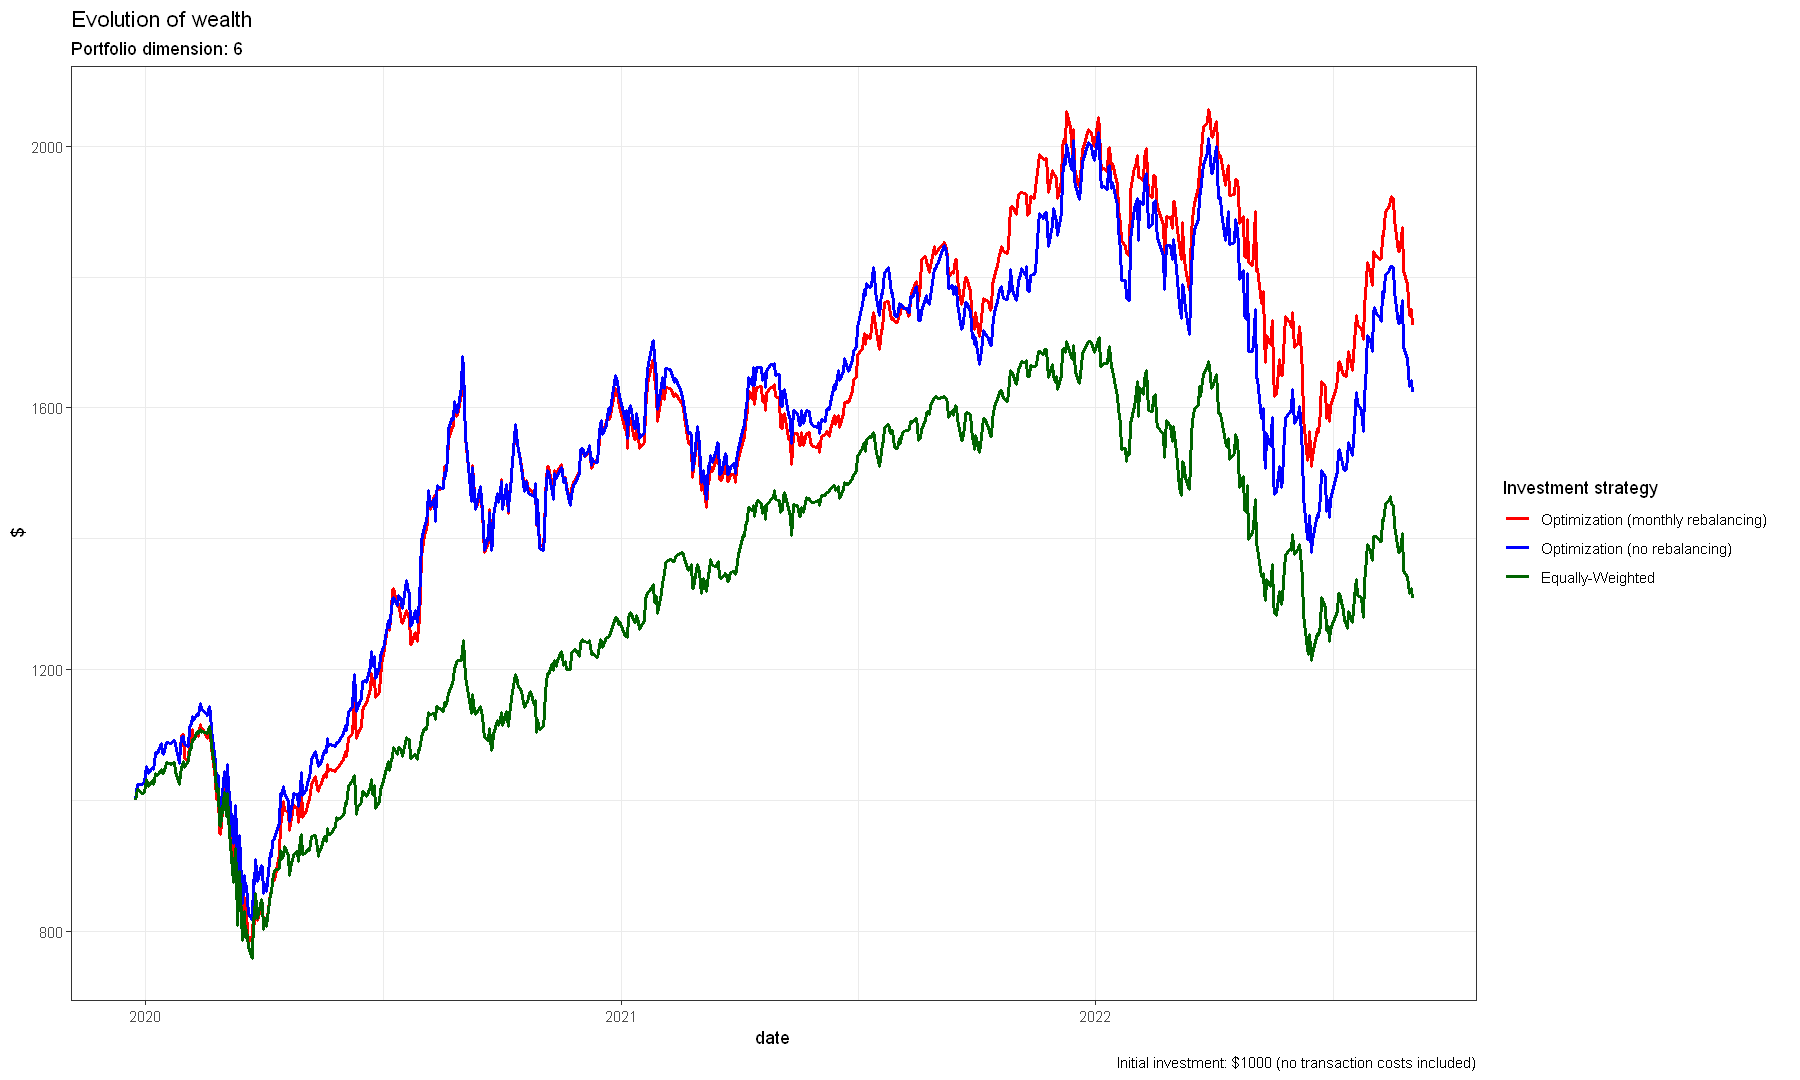

In [41]:
methods <- c("Optimization (monthly rebalancing)" = "red",
             "Optimization (no rebalancing)" = "blue",
             "Equally-Weighted"="darkgreen")
ewfigure <- ggplot(wealthdf, aes(x = Date)) +
  geom_line(aes(y = OptimizationA, color="Optimization (monthly rebalancing)"), linetype = "solid", size = 1) +
  geom_line(aes(y = OptimizationB, color="Optimization (no rebalancing)"), linetype = "solid", size = 1) +
  geom_line(aes(y = EW, color="Equally-Weighted"), linetype = "solid", size = 1) +
  labs(title = "Evolution of wealth",
       subtitle = paste0("Portfolio dimension: ", d),
       caption = paste0("Initial investment: $", W0," (no transaction costs included)"),
       color = "Investment strategy",
       x = "date",
       y = "$") +
  scale_color_manual(values = methods)
options(repr.plot.width=15, repr.plot.height=9)
ewfigure +  theme_bw(base_line_size = 0.1)

In [54]:
print("Fund B (blue line) strategy:")
print(round(weights[1,],4))

[1] "Fund B (blue line) strategy:"
  AAPL   AMZN   MSFT  GOOGL  BRK.A    JPM 
0.6308 0.2604 0.0039 0.0000 0.1048 0.0000 


Fund B keeps its portfolio allocation fixed over time. They invest almost the whole capital in three stocks: APPL (63.08%), AMZN (26.04%) and BRK.A (10.48%). Nothing is invested neither in GOOGL nor JPM. From the previous figure, it can be seen how god performs this strategy (blue line) against an equally-weighted strategy (green line).

### 5.2. How weights vary across time?
Fund A (red line) rebalances portfolio weights monthly (each 20 labor days). How does the vector of weights vary over time? 

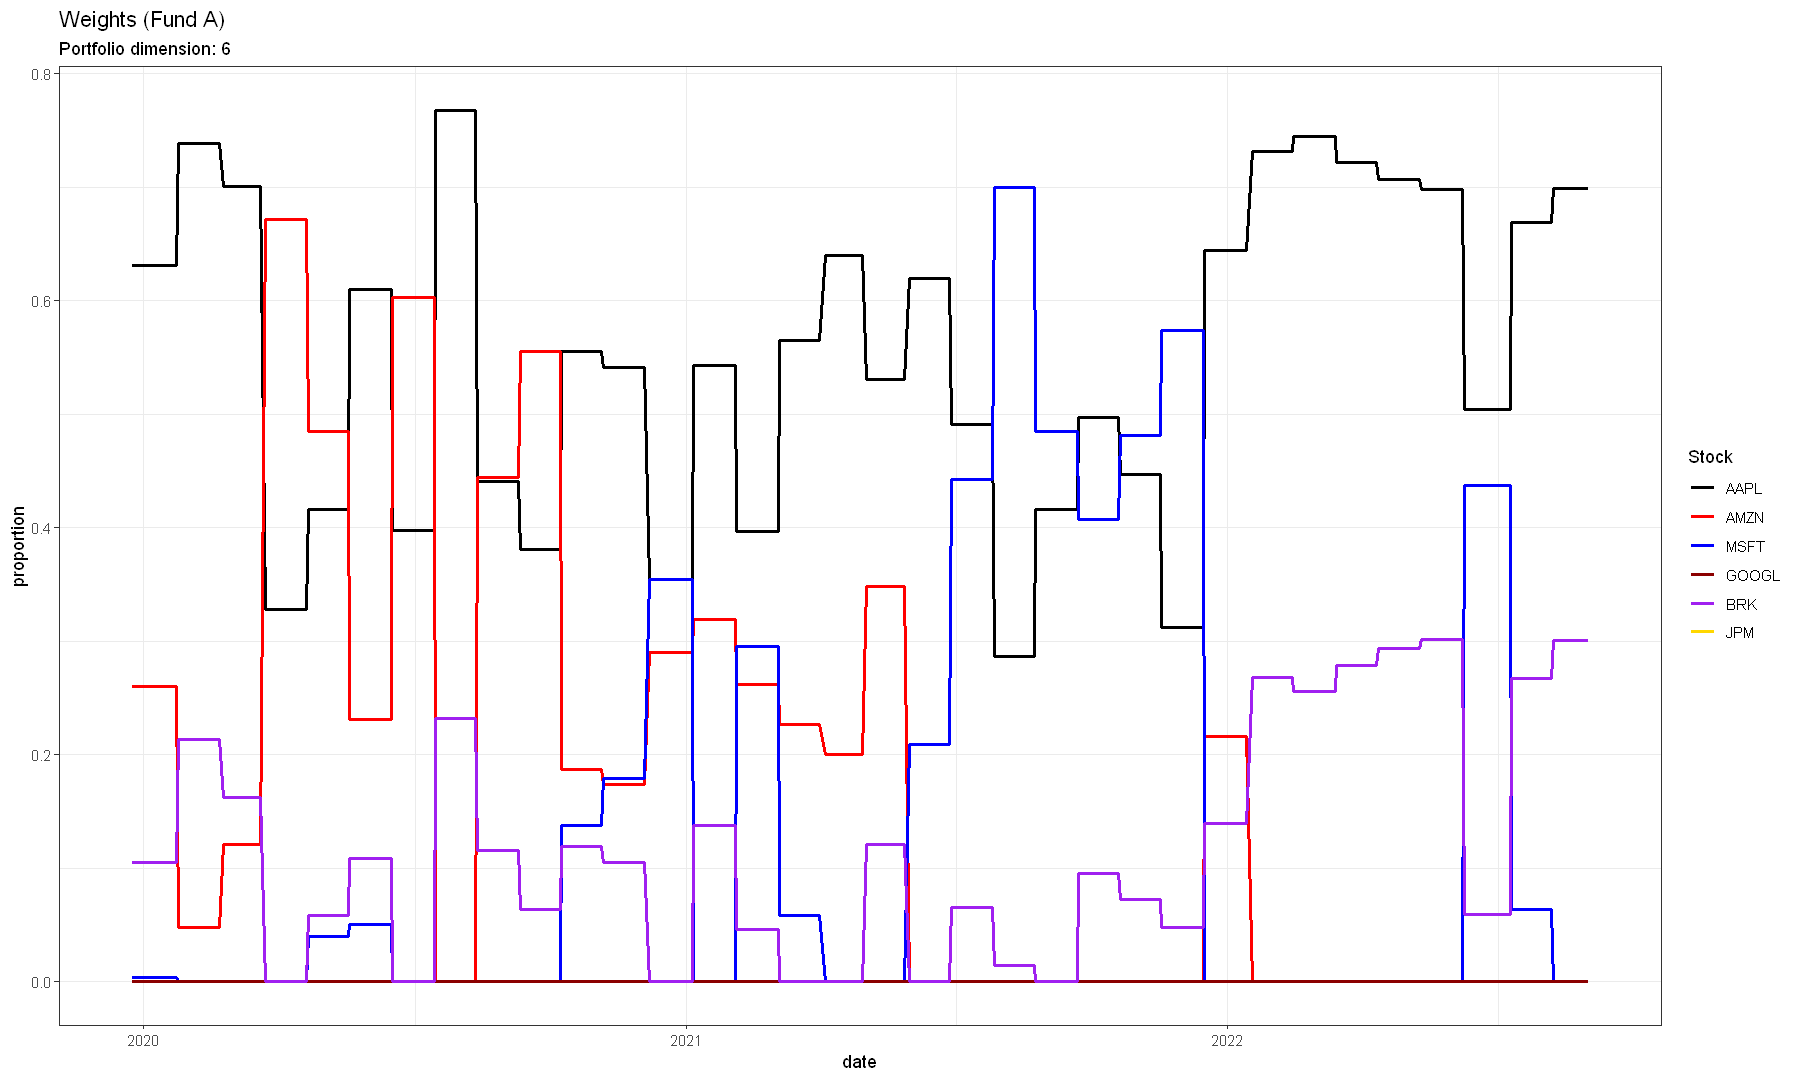

In [62]:
weightsdf <- data.frame(Date,weights)
colnames(weightsdf) <-  c("date","AAPL", "AMZN", "MSFT", "GOOGL", "BRK", "JPM")

names <- c("AAPL"="black","AMZN"="red","MSFT"="blue","GOOGL"="darkred","BRK"="purple","JPM"="gold")
wfigure <- ggplot(weightsdf, aes(x = Date)) +
  geom_line(aes(y = AAPL, color="AAPL"), linetype = "solid", size = 1) +
  geom_line(aes(y = AMZN, color="AMZN"), linetype = "solid", size = 1) +
  geom_line(aes(y = MSFT, color="MSFT"), linetype = "solid", size = 1) +
  geom_line(aes(y = GOOGL, color="GOOGL"), linetype = "solid", size = 1) +
  geom_line(aes(y = BRK, color="BRK"), linetype = "solid", size = 1) +
  geom_line(aes(y = BRK, color="BRK"), linetype = "solid", size = 1) +
  labs(title = "Weights (Fund A)",
       subtitle = paste0("Portfolio dimension: ", d),
       #caption = ,
       color = "Stock",
       x = "date",
       y = "proportion") +
  scale_color_manual(values = names)
options(repr.plot.width=15, repr.plot.height=9)
wfigure +  theme_bw(base_line_size = 0.1) 

From the previous figure, it is observed some variability in portfolio allocation weights over time. The transaction costs associated to this changes in portfolio allocation  (buyin/selling stocks) may mitigate their benefits. 

According to the previous analysis, we conclude that the best strategy would be that followed by Fund B.

### 5.3. Some remarks

In [14]:
print(tail(wealthdf,1))
diff1 <- round(tail(wealthdf[,"OptimizationA"],1)- tail(wealthdf[,"EW"],1),2)
diff2 <- round(tail(wealthdf[,"OptimizationB"],1)- tail(wealthdf[,"EW"],1),2)
paste0("At the end of the investment horizon, the gap between portfolio values of funds A and C is $", diff1, " (no transaction costs included)")
paste0("At the end of the investment horizon, the gap between portfolio values of funds B and C is $", diff2)

          Date OptimizationA OptimizationB       EW
679 2022-09-02      1707.574      1622.043 1308.224


[1] "At the end of the investment horizon, the gap between portfolio values of funds A and C is $399.35 (no transaction costs included)"

[1] "At the end of the investment horizon, the gap between portfolio values of funds B and C is $313.82"

We simulated the strategies of three funds, A, B and C. The three of them invested $1,000 in 2019-12-23 but follow different stratefies:
* **Fund A**: econometrical approach to choose portfolio weights, updating weights every 20 labor days (monthly rebalancing). 
* **Fund B:** econometrical approach to choose portfolio weights. Solve the optimization problem once and keep the strategy fixed during the whole investment horizon.
* **Fund C:** equally-weighted strategy, i.e., they invested the same proportion in each stock and never rebalanced those weights.

In this specific case, the strategy followed by fund A yields to much higer benefits than the ones followed by funds B and C, however, transaction costs are not included.  Transaction costs could mitigate Fund A's benefits from rebalancing, being Fund B's the better option. It would be interesting to explore other periodicity for rebalancing, e.g., annually or semi-annually. Optimal portfolios are found according to Rockafellar and Uryasev (2000). The strategy is given by choosing the global minimum risk portfolio. So that, given a set of stocks, this optimization problem finds the allocation that minimizes market risk (measured by the expected shortfall).

Note: notice that in this exercise, we discretionary select 6 stocks constituents of the S&P 500. In practice, we should follow some criteria to decide which stocks should be included in the portfolio. However, the main goal of this exercise is to illustrate the rolling window approach and how an econometric approach based on GJR-GARCH models, copulas and Rockafellar and Uryasev (2000) may yield to better portfolio performance with respect to an equally-weighted strategy.